# 2.2. Project Planning + Sourcing Data with an API

## This script contains the following:
#### [1. Import Libraries](#import-libraries)
#### [2. Import Data](#import-data)
#### [3. Getting Weather Data Using NOAA's API](#noaa-api)
#### [4. Wrangle Weather Data](#wrangle-weather)
#### [5. Wrangle Bike Rental Data](#wrangle-bike)
#### [6. Merge the Data](#merge)
#### [7. Export the Data](#export-data)

### 1. Import Libraries<a class="anchor" id="import-libraries"></a>

In [4]:
import pandas as pd 
import numpy as np
import os 
import requests
import json
import seaborn as sns
from datetime import datetime

### 2. Import Data<a class="anchor" id="import-data"></a>

Downloaded data was unzipped and stored in the 'Raw Data' folder. There were a total of 36 csv files.

In [7]:
# Create a list with all files in the folder using a list compehension
folderpath = r'/Users/matthewjones/Documents/CareerFoundry/Data Visualization with Python/Achievement 2/NY-CitiBike/2. Data/Raw Data'
filepaths  = [os.path.join(folderpath, name) for name in os.listdir(folderpath)]

In [8]:
# Read and concatenate all files simultaneously
df = pd.concat((pd.read_csv(f, low_memory=False, encoding="utf-8") for f in filepaths), ignore_index = True)

#### NOTE ON LIST COMPREHENSION:
    The data is joined together using a list comprehension because it requires very little code to do the same thing as a for loop. List comprehension is also optimized for Python for speed. So this solution is both faster for the coder and faster for the machine.

In [10]:
# Check the output
df.shape

(29838806, 14)

In [11]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Unnamed: 0
0,9D0DC440CB40CF8E,electric_bike,2022-08-27 13:56:47.728,2022-08-27 14:02:56.651,Flatbush Ave & Ocean Ave,3704.04,3 St & Prospect Park West,3865.05,40.663657,-73.963014,40.668132,-73.973638,casual,NaN
1,2214991DFBE5C4D7,electric_bike,2022-08-20 10:37:02.756,2022-08-20 10:45:56.631,Forsyth St\t& Grand St,5382.07,E 11 St & 1 Ave,5746.14,40.717798,-73.993161,40.729538,-73.984267,casual,NaN
2,20C5D469563B6337,classic_bike,2022-08-31 18:55:03.051,2022-08-31 19:03:37.344,Perry St & Bleecker St,5922.07,Grand St & Greene St,5500.02,40.735354,-74.004831,40.721700,-74.002381,member,NaN
3,3E8791885BC189D1,classic_bike,2022-08-02 08:05:00.250,2022-08-02 08:16:52.063,FDR Drive & E 35 St,6230.04,Grand Army Plaza & Central Park S,6839.10,40.744219,-73.971212,40.764397,-73.973715,member,NaN
4,8DBCBF98885106CB,electric_bike,2022-08-25 15:44:48.386,2022-08-25 15:55:39.691,E 40 St & 5 Ave,6474.11,Ave A & E 14 St,5779.11,40.752052,-73.982115,40.730311,-73.980472,member,NaN


### 3. Get Weather Data Using NOAA's API<a class="anchor" id="noaa-api"></a>

In [13]:
# Define the NOAA token
Token = 'EiMgIfAgdwaDOqpoeQltDBtFvzjbnSIZ' 

In [14]:
# Get the API 
r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG&limit=1000&stationid=GHCND:USW00014732&startdate=2022-01-01&enddate=2022-12-31', headers={'token':Token})

In [15]:
# Load the API response as a json
d = json.loads(r.text)

### 4. Wrangle Weather Data<a class="anchor" id="wrangle-weather"></a>

In [17]:
# Secure all items in the response that correspond to TAVG
avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']

In [18]:
# Create a list of the date from all average temperature readings
dates_temp = [item['date'] for item in avg_temps]

In [19]:
# Create a list of the temperature from all average temperature readings

temps = [item['value'] for item in avg_temps]

In [20]:
# Initialize a dataframe
df_temp = pd.DataFrame()

In [21]:
# Create two columns in the new dataframe corresponding to the two lists
df_temp['date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_temp] # Cast date to datetime
df_temp['avgTemp'] = [float(v)/10.0 for v in temps] # Convert temperature from tenths of Celsius to normal Celsius

<Axes: xlabel='date', ylabel='avgTemp'>

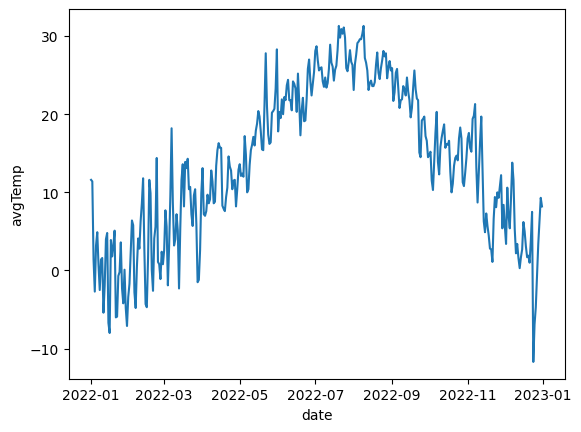

In [22]:
# Plot temperature by date in a line plot
sns.lineplot(data=df_temp, x="date", y="avgTemp")

# Checking the data to ensure data consistency

### 5. Wrangle Bike Rental Data<a class="anchor" id="wrangle-bike"></a>

In [24]:
# Check the datatypes of df
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
Unnamed: 0             object
dtype: object

In [25]:
# Convert 'started at' date to datetime
df['started_at'] = pd.to_datetime(df['started_at'], dayfirst = False)

In [26]:
# Create a new column in df that matches the 'date' column df_temps
df['date'] = pd.to_datetime(df['started_at'], format='%Y-%m-%d').dt.date # We don't need time information
df['date'] = pd.to_datetime(df['date'])

### 6. Merge the Data<a class="anchor" id="merge"></a>

In [28]:
%%time

# Left merge df with df_temp on the 'date' columns
df_merged = df.merge(df_temp, how = 'left', on = 'date', indicator = True)

CPU times: user 6.02 s, sys: 5.63 s, total: 11.6 s
Wall time: 13.7 s


In [29]:
# Check to see if it was a full match
df_merged['_merge'].value_counts(dropna = False)

_merge
both          29838166
left_only          640
right_only           0
Name: count, dtype: int64

#### Check the rows that only merged from the left

In [31]:
# Subset merged dataframe to only contain the rows that didn't merge with df_temps
df_merged_left = df_merged.loc[df_merged['_merge'] == 'left_only']

In [32]:
# Check the output
df_merged_left.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Unnamed: 0,date,avgTemp,_merge
5822796,FA436228F4CD7647,classic_bike,2021-02-15 14:11:20.946,2022-08-10 15:01:30.839,Kent Ave & S 11 St,5062.01,Union Ave & Jackson St,5300.06,40.707645,-73.968415,40.716075,-73.952029,casual,NaN,2021-02-15,NaN,left_only
8523027,FB5A88EC9510F0D3,classic_bike,2021-12-31 15:54:01.151,2022-03-18 22:30:45.213,E 67 St & Park Ave,6932.14,Pier 40 Dock Station,SYS035,40.767801,-73.965921,40.728660,-74.011980,casual,NaN,2021-12-31,NaN,left_only
9866906,BD86E7D0ACCC39B8,classic_bike,2021-11-22 21:28:35.151,2022-03-03 13:58:33.381,Willis Ave & E 137 St,7726.02,Pier 40 Dock Station,SYS035,40.808384,-73.923604,40.728660,-74.011980,casual,NaN,2021-11-22,NaN,left_only
9876393,8AFBCFEE21703C2D,classic_bike,2021-04-30 16:56:21.003,2022-03-08 17:18:57.580,Bedford Ave & Nassau Ave,5550.05,Lorimer St & Broadway,4965.01,40.723117,-73.952123,40.704118,-73.948186,casual,NaN,2021-04-30,NaN,left_only
10240287,50359EEC11CE38D2,classic_bike,2021-12-12 05:18:01.991,2022-03-05 08:10:31.464,Lafayette Ave & Hunts Point Ave,7883.06,E 58 St & 3 Ave,6762.02,40.816567,-73.888161,40.760958,-73.967245,casual,NaN,2021-12-12,NaN,left_only


#### NOTE ABOUT MERGE
    640 rows in df did not have a corresponding entry in df_temp. When we look at these rows in a subset, we can see that all of these rows have bike rentals that began in 2021. Since our weather data is only for 2022, these rows will not have weather data. When cleaning this dataset, we may consider removing these rows.

### 7. Export the Data<a class="anchor" id="export-data"></a>

In [35]:
# Set the destination path for processed data
destpath = r'/Users/matthewjones/Documents/CareerFoundry/Data Visualization with Python/Achievement 2/NY-CitiBike/2. Data/Processed Data'

df_merged.to_csv(os.path.join(destpath, 'nyc_bike_weather_data.csv'))